In [8]:
import pandas as pd
import numpy as np
import talib
import os
import matplotlib.pyplot as plt


In [9]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum'
    })

    # 3. 整理列名称（可选）
    # df_minute.columns = ['_'.join(col).strip() for col in df_minute.columns.values]
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [ ]:
# dirpath = 'FutSF_TickKZ_CTP_Daily_202301'
# direc = os.listdir(dirpath)

# wholef = pd.DataFrame()
# for file_name in direc:
#     if 'IC' not in file_name:
#         continue
#     df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

#     f = df[['最新价','数量']].copy()
#     f.columns = ['price','volume']
#     f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
#     ff = tick_to_minute(f, freq="min").iloc[:-4,:]
#     wholef=pd.concat([wholef,ff],ignore_index=True)

dirpath = 'data/IC'
direc = os.listdir(dirpath)

wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
    wholef=pd.concat([wholef,ff],ignore_index=True)


In [ ]:
dirpath = 'data/IC'
direc = os.listdir(dirpath)
pre,cur = direc[0],direc[1]
pref,df = pd.read_csv(os.path.join(dirpath,pre), encoding='gbk'),pd.read_csv(os.path.join(dirpath,cur), encoding='gbk')

,ActionDay,AskPrice1,AskPrice2,AskPrice3,AskPrice4,AskPrice5,AskVolume1,AskVolume2,AskVolume3,AskVolume4,...,PreDelta,PreOpenInterest,PreSettlementPrice,SettlementPrice,TradingDay,Turnover,UpdateMillisec,UpdateTime,UpperLimitPrice,Volume
0,20230302,NaN,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,0.000000e+00,200,07:04:57,7026.4,0
1,20230302,6390.0,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,1.623009e+08,200,09:29:00,7026.4,127
2,20230302,6387.8,NaN,NaN,NaN,NaN,6,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.019016e+08,200,09:30:00,7026.4,158
3,20230302,6386.6,NaN,NaN,NaN,NaN,4,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.478816e+08,700,09:30:00,7026.4,194
4,20230302,6384.4,NaN,NaN,NaN,NaN,1,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.683130e+08,200,09:30:01,7026.4,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25411,20230302,6381.6,NaN,NaN,NaN,NaN,1,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.374272e+10,200,14:59:59,7026.4,34278
25412,20230302,6382.4,NaN,NaN,NaN,NaN,10,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.374910e+10,700,14:59:59,7026.4,34283
25413,20230302,6382.2,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.375165e+10,200,15:00:00,7026.4,34285
25414,20230302,6382.2,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,6374.8,20230302,4.375165e+10,200,15:28:02,7026.4,34285


In [ ]:
class Variable:

    def __init__(self,para,df):
        self.para = para
        self.df = df
        self.SRevert = -np.inf
        self.BRevert = np.inf
        self.div = 3
        self.ifSetup = None
    
    def CalFixedBands(self):
        r1,r2,r3 = self.para
        H,L,C = max(self.df['LastPrice']),min(self.df['LastPrice']),self.df['LastPrice'].iloc[-1]

        self.SEnter = ((1 + r1)/2 *(H + C)) - r1 * L
        self.BEnter = ((1 + r1) / 2 * (L + C)) - r1 * H
        self.SSetup = H + r2 * (C - L)
        self.BSetup = L - r2 * (H - C)
        self.BBreak = self.SSetup + r3 * (self.SSetup - self.BSetup)
        self.SBreak = self.BSetup - r3 * (self.SSetup - self.BSetup)
    
    def CalFloatingBand(self,tdhigh,tdlow):
        self.SRevert = self.SEnter + (tdhigh - self.SSetup) / self.div
        self.BRevert = self.BEnter + (tdlow - self.BSetup) / self.div


In [ ]:
def rbreaker_backtest(df,pref, para = [0.01,0.01,0.01], atr_period=2, add_threshold=0.5, stop_loss_mult=2, cost = 0.6):
    
    if df['InstrumentID'][0] != pref['InstrumentID'][0]:
        return
    
    df,pref = df.copy(),pref.copy()

    variable = Variable(para,pref)
    variable.CalFixedBands()
    
    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    df = tick_to_minute(f, freq="min").iloc[1:-2,:]

    # 计算 ATR（周期为 atr_period）
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(len(df)):
        current_date = df.index[i]
        close,high,low = df.iloc[i]['close'],df.iloc[i]['high'],df.iloc[i]['low']
        atr = df.iloc[i]['ATR']
        
        if high > variable.BBreak and variable.BBreak > variable.SRevert:
            if position < 0:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })

        if low < variable.SBreak and variable.SBreak < variable.BRevert:
            if position > 0:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })

        if variable.ifSetup == 'BSetup':
            if high > variable.BRevert:
                if position < 0:
                    pnl = sum([price - close - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                if position == 0:
                    position = 1
                    entry_prices = [close]
                    last_entry = close
                    df.at[current_date, 'Signal'] = 1
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log.append({
                        'Entry_Date': current_date,
                        'Direction': 'Long',
                        'Entry_Prices': entry_prices.copy()
                    })
        if variable.ifSetup == 'SSetup':
            if low < variable.SRevert:
                if position > 0:
                    pnl = sum([close - price - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                    if position == 0:
                        position = -1
                        entry_prices = [close]
                        last_entry = close
                        df.at[current_date, 'Signal'] = -1
                        df.at[current_date, 'Trade_Price'] = close
                        trade_log.append({
                            'Entry_Date': current_date,
                            'Direction': 'Short',
                            'Entry_Prices': entry_prices.copy()
                        })
        if position > 0:
            if high >= last_entry + add_threshold * atr:
                position += 1
                entry_prices.append(close)
                last_entry = close  # 更新最新入场价格
                df.at[current_date, 'Signal'] = 1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()
            # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
            elif low <= last_entry - stop_loss_mult * atr:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
        
        if position < 0:
            if low <= last_entry - add_threshold * atr:
                position -= 1
                entry_prices.append(close)
                last_entry = close
                df.at[current_date, 'Signal'] = -1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()

            elif high >= last_entry + stop_loss_mult * atr:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

        variable.CalFloatingBand(df['high'].iloc[i],df['low'].iloc[i])
        if high > variable.SSetup:
            variable.ifSetup = 'SSetup'
        if low < variable.BSetup:
            variable.ifSetup = 'BSetup'

        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price - cost for price in entry_prices])
        else:
            pnl = sum([price - final_price - cost for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None
    
    return df, trade_log

In [30]:
rbreaker_backtest(df,pref)

(               datetime    open    high     low   close   volume        ATR  \
 145 2023-03-03 09:29:00  6391.4  6391.4  6391.4  6391.4       66        NaN   
 146 2023-03-03 09:30:00  6392.4  6392.8  6383.8  6383.8    67947        NaN   
 147 2023-03-03 09:31:00  6383.8  6392.6  6381.4  6391.4   121118  10.100000   
 148 2023-03-03 09:32:00  6391.4  6394.8  6388.0  6394.0   166117   8.450000   
 149 2023-03-03 09:33:00  6395.0  6397.0  6394.0  6394.4   225913   5.725000   
 ..                  ...     ...     ...     ...     ...      ...        ...   
 472 2023-03-03 14:56:00  6373.4  6375.8  6373.4  6374.8  4671752   2.280124   
 473 2023-03-03 14:57:00  6375.2  6376.8  6374.2  6375.0  4792078   2.440062   
 474 2023-03-03 14:58:00  6375.0  6375.0  6373.0  6373.8  4755187   2.220031   
 475 2023-03-03 14:59:00  6374.4  6376.8  6372.2  6372.6  4788105   3.410016   
 476 2023-03-03 15:00:00  6372.6  6372.6  6372.6  6372.6    40723   1.705008   
 
      Signal  Position  Trade_Price  C

In [ ]:
def apply_rbreaker_strategy(df, levels, max_add_positions=2):
    """应用 R-Breaker 策略，使用海龟加仓逻辑 (0.5 ATR)"""
    df['ATR'] = df['High'] - df['Low']  # 计算简单 ATR，这里假设没有更复杂的 ATR 计算
    atr_value = df['ATR'].mean() * 0.5  # 取 0.5 ATR 作为加仓阈值
    
    df['Position'] = 0  # 0: 空仓, 1: 做多, -1: 做空
    df['AddPosition'] = 0  # 记录加仓次数
    in_position = 0
    
    for i in df.index:
        price = df.at[i, 'Close']
        
        if in_position == 0:
            if price > levels['BreakoutBuy']:
                df.at[i, 'Position'] = 1  # 突破做多
                in_position = 1
            elif price < levels['BreakoutSell']:
                df.at[i, 'Position'] = -1  # 突破做空
                in_position = -1
        
        elif in_position == 1:
            if price > levels['BreakoutBuy'] + atr_value and df.at[i, 'AddPosition'] < max_add_positions:
                df.at[i, 'Position'] = 1  # 海龟加仓
                df.at[i, 'AddPosition'] += 1
            elif price < levels['EnterSell']:
                df.at[i, 'Position'] = -1  # 反转做空
                df.at[i, 'AddPosition'] = 0
                in_position = -1
        
        elif in_position == -1:
            if price < levels['BreakoutSell'] - atr_value and df.at[i, 'AddPosition'] < max_add_positions:
                df.at[i, 'Position'] = -1  # 海龟加仓
                df.at[i, 'AddPosition'] += 1
            elif price > levels['EnterBuy']:
                df.at[i, 'Position'] = 1  # 反转做多
                df.at[i, 'AddPosition'] = 0
                in_position = 1
    
    return df

def backtest(df):
    """回测策略，包含交易成本"""
    trading_cost = 0.0004  # 交易成本万分之四
    df['Returns'] = df['Close'].pct_change() * df['Position'].shift(1)
    df['Returns'] = df['Returns'] - trading_cost * (df['Position'].shift(1) != df['Position'])
    df['Cumulative Returns'] = (1 + df['Returns']).cumprod()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative Returns'], label='R-Breaker Strategy')
    plt.axhline(1, color='black', linestyle='--', alpha=0.7)
    plt.title('R-Breaker Strategy Cumulative Returns')
    plt.legend()
    plt.show()
    
    return df

In [ ]:
result, trades = turtle_backtest(wholef, channel_period=2, atr_period=2, add_threshold=0.2, stop_loss_mult=2.4)

# 输出最后几行回测结果
print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

total_pnl = 0
# 输出交易记录
print("交易记录：")
for trade in trades:
    print(trade)
    total_pnl += trade.get('PnL', 0)
print(total_pnl)

         open    high     low   close       ATR  Donchian_High  Donchian_Low  \
76266  4915.2  4920.8  4915.2  4920.6  4.828639         4925.8        4901.0   
76267  4920.8  4921.0  4919.2  4920.2  3.314319         4925.8        4904.2   
76268  4919.8  4924.0  4919.8  4924.0  3.757160         4925.8        4904.2   
76269  4923.8  4925.4  4921.0  4922.8  4.078580         4925.8        4904.2   
76270  4922.6  4924.0  4922.6  4923.4  2.739290         4925.8        4904.2   

       Signal  Position  Cum_PnL  
76266       0         0  -2137.6  
76267       0         0  -2137.6  
76268       0         0  -2137.6  
76269       0         0  -2137.6  
76270       0         0  -2137.6  
交易记录：
{'Entry_Date': 40, 'Direction': 'Short', 'Entry_Prices': [6383.0, 6376.6, 6374.6, 6372.2, 6371.0, 6369.2], 'Exit_Date': 89, 'Exit_Price': 6379.2, 'PnL': -28.599999999998545}
{'Entry_Date': 136, 'Direction': 'Short', 'Entry_Prices': [6372.0, 6370.4, 6369.6, 6366.2, 6364.2], 'Exit_Date': 154, 'Exit_Price

In [194]:
maxholding = 0
winrate = 0
total_trades = 0
for trade in trades:
    maxholding = max(maxholding,len(trade['Entry_Prices']))
    total_trades += len(trade['Entry_Prices'])
    if trade.get('PnL', 0) > 0:
        winrate += len(trade['Entry_Prices'])
winrate = winrate/total_trades
winrate

0.3996014423989372

In [195]:
result

,datetime,open,high,low,close,volume,ATR,Donchian_High,Donchian_Low,Signal,Position,Trade_Price,Cum_PnL
0,2023-03-02 09:29:00,6389.8,6389.8,6389.8,6389.8,127,NaN,NaN,NaN,0,0,NaN,0.0
1,2023-03-02 09:30:00,6385.2,6391.0,6383.6,6388.6,65462,NaN,NaN,NaN,0,0,NaN,0.0
2,2023-03-02 09:31:00,6388.8,6394.0,6388.0,6393.0,131105,6.700000,NaN,NaN,0,0,NaN,0.0
3,2023-03-02 09:32:00,6393.2,6395.0,6388.6,6392.6,213605,6.550000,NaN,NaN,0,0,NaN,0.0
4,2023-03-02 09:33:00,6392.6,6392.6,6386.2,6388.6,248803,6.475000,NaN,NaN,0,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76266,2024-06-25 14:55:00,4915.2,4920.8,4915.2,4920.6,6174046,4.828639,4925.8,4901.0,0,0,NaN,-2137.6
76267,2024-06-25 14:56:00,4920.8,4921.0,4919.2,4920.2,6097425,3.314319,4925.8,4904.2,0,0,NaN,-2137.6
76268,2024-06-25 14:57:00,4919.8,4924.0,4919.8,4924.0,6184821,3.757160,4925.8,4904.2,0,0,NaN,-2137.6
76269,2024-06-25 14:58:00,4923.8,4925.4,4921.0,4922.8,6003023,4.078580,4925.8,4904.2,0,0,NaN,-2137.6


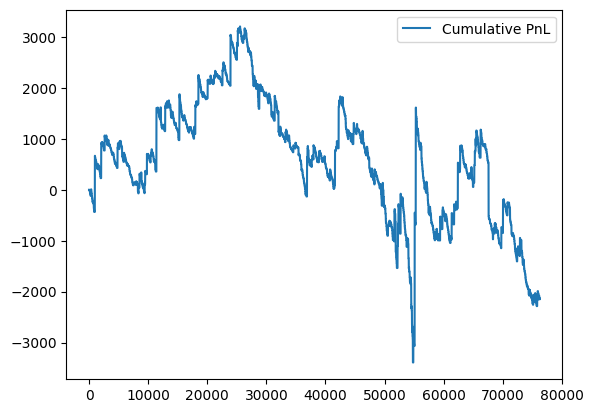

In [196]:
import matplotlib.pyplot as plt
# plt.plot(result['close'], label='Close Price')
# plt.plot(result['Donchian_High'], label='Donchian High')
# plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.plot(result['Cum_PnL'], label='Cumulative PnL')
plt.legend()
plt.show()

In [177]:
dirpath = 'data/IM'
direc = os.listdir(dirpath)
ttpnl = []
wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-4,:]

    result, trades = turtle_backtest(ff, channel_period=2, atr_period=2, add_threshold=0.1, stop_loss_mult=2.4)

    # 输出最后几行回测结果
    # print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

    day_pnl = 0
    # 输出交易记录
    # print("交易记录：")
    for trade in trades:
        day_pnl += trade.get('PnL', 0)
    ttpnl.append(day_pnl)
    print(day_pnl,file_name)

-192.00000000000182 IM_20230302.csv
-274.99999999999727 IM_20230303.csv
-226.79999999999654 IM_20230306.csv
-238.40000000000236 IM_20230307.csv
-200.80000000000382 IM_20230308.csv
-348.3999999999969 IM_20230309.csv
-189.8000000000011 IM_20230310.csv
-488.199999999998 IM_20230313.csv
-365.99999999999454 IM_20230314.csv
-234.59999999999854 IM_20230315.csv
-257.99999999999363 IM_20230316.csv
-211.39999999999964 IM_20230317.csv
-173.19999999999254 IM_20230320.csv
-377.40000000000236 IM_20230321.csv
-217.20000000000346 IM_20230323.csv
-161.5999999999931 IM_20230324.csv
-172.59999999999945 IM_20230327.csv
-175.00000000000546 IM_20230328.csv
-111.20000000000528 IM_20230329.csv
-671.3999999999978 IM_20230330.csv
-258.0000000000009 IM_20230331.csv
-106.00000000000455 IM_20230403.csv
-177.800000000002 IM_20230404.csv
-147.59999999999854 IM_20230406.csv
-327.39999999999964 IM_20230407.csv
-196.60000000000218 IM_20230410.csv
-63.599999999999454 IM_20230411.csv
-124.79999999999836 IM_20230412.csv
-

In [166]:
local_path = 'E:/ryse/LocalDatabase'
code = 'IM'
# os.makedirs(f'data/{code}', exist_ok=True)
f = pd.read_csv(local_path + '/' + code + '.csv')

f = f[f['Date'] >= 20230302].reset_index(drop=True)

for dt in range(len(f['Date'])):
    date = f['Date'][dt]
    filename = f'{code}_{date}.csv'
    if not os.path.exists(f'data/{code}/{filename}'):
        print(f'Not Processed {filename}')
    if date == 20230829:
        continue

Not Processed IM_20230322.csv
Not Processed IM_20230428.csv
Not Processed IM_20230814.csv
Not Processed IM_20230829.csv
Not Processed IM_20250311.csv
Not Processed IM_20250312.csv
Not Processed IM_20250313.csv
Not Processed IM_20250314.csv
Not Processed IM_20250317.csv
